In [1]:
# install libraries if not already installed
!pip3 install pandas
!pip3 install --user pandas_profiling
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install lightgbm
!pip3 install catboost
!pip3 install xgboost
!pip3 install numpy
!pip3 install dill

In [2]:
# import libraries needed
import warnings
warnings.filterwarnings("ignore")

import dill
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import seaborn as sns
import numpy as np



/usr/local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

In [ ]:
# load notebook session
dill.load_session('notebook_env.db')

# Outline
1. Data Overview and Preprocessing <br/>
    A. Data Loading <br/>
    B. Exploratory Data Analysis (EDA) <br/>
    C. Data Preprocessing <br/>
    D. Data Splitting <br/>
2. Experiments and Analyses 
    1. Experiments <br/>
      a. Classification Models <br/>
      b. 10F-Cross Validation <br/>
      c. Model Performance Comparison <br/>
      d. Hyper-parameter Optimisation <br/>
      e. Tuned Model Performance on Test Set <br/>
    2. Analyses <br/>
      a. ROC Curve <br/>
      b. Top Feature Predictors <br/>

# 1. Data Overview and Preprocessing

## A. Data Loading

In [3]:
# load data with column names from documentation
cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num' ]
data = pd.read_csv('data/processed.cleveland.data', header=None, names=cols)

In [4]:
# check that data is loaded properly
data.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0

## B. Exploratory Data Analysis (EDA)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [6]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Observations
1. No missing values, no duplicate rows.
2. Some variables have invalid values (?) namely ca and thal. We replace it with the most frequent value. 
3. The target variable num has 5 values. Following previous approaches, these 5 variables can be grouped into 2 name for presence (1,2,3,4) and absence (0) of heart failure and formulate this as a binary classification task.  

## C. Data Preprocessing

In [7]:
# Replace invalid values with the most frequent values. In ca, replace ? with 0. In thal, replace ? with 3. 
data.ca.replace({'?':'0.0'}, inplace=True)
data.thal.replace({'?':'3.0'}, inplace=True)

# Replace num values (1,2,3,4) with 1
data.num.replace({1:1, 2:1, 3:1, 4:1}, inplace=True)

In [8]:
# Verify changes
print(data.ca.value_counts())
print(data.thal.value_counts())
print(data.num.value_counts())

0.0    180
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64
3.0    168
7.0    117
6.0     18
Name: thal, dtype: int64
0    164
1    139
Name: num, dtype: int64


## D. Data Splitting
Create train, validation, test sets



In [9]:
# Separate input and target variables
X = data.iloc[:, 0:13].values
y = data.iloc[:, 13:].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [11]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 303
Total # of sample in train dataset: 203
Total # of sample in validation dataset: 50
Total # of sample in test dataset: 50


# 2. Experiments and Analyses

## A. Experiments

### a. Classification Models

In [12]:
# classification models
log = LogisticRegression(solver="liblinear",penalty='l2', C=0.1).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
ran = RandomForestClassifier(random_state=50).fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
gbc = GradientBoostingClassifier(verbose=False).fit(X_train, y_train)
xgbc = XGBClassifier().fit(X_train, y_train)
lgbmc = LGBMClassifier().fit(X_train, y_train)
catbc = CatBoostClassifier().fit(X_train, y_train)
models = [log, dtc, ran, knn, gbc, xgbc, lgbmc, catbc]

/usr/local/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Learning rate set to 0.005215
0:	learn: 0.6889287	total: 54.3ms	remaining: 54.2s
1:	learn: 0.6846399	total: 55.5ms	remaining: 27.7s
2:	learn: 0.6813697	total: 56.3ms	remaining: 18.7s
3:	learn: 0.6771864	total: 57.3ms	remaining: 14.3s
4:	learn: 0.6729900	total: 58.4ms	remaining: 11.6s
5:	learn: 0.6698433	total: 59.5ms	remaining: 9.86s
6:	learn: 0.6665595	total: 60.5ms	remaining: 8.59s
7:	learn: 0.6625959	total: 62.4ms	remaining: 7.74s
8:	learn: 0.6589117	total: 63.6ms	remaining: 7s
9:	learn: 0.6555238	total: 64.7ms	remaining: 6.41s
10:	learn: 0.6525207	total: 65.9ms	remaining: 5.93s
11:	learn: 0.6487577	total: 67.1ms	remaining: 5.52s
12:	learn: 0.6447625	total: 68.2ms	remaining: 5.18s
13:	learn: 0.6410422	total: 69.4ms	remaining: 4.88s
14:	learn: 0.6383704	total: 70.5ms	remaining: 4.63s
15:	learn: 0.6352979	total: 71.6ms	remaining: 4.4s
16:	learn: 0.6334510	total: 72.7ms	remaining: 4.2s
17:	learn: 0.6302764	total: 73.8ms	remaining: 4.02s
18:	learn: 0.6271896	total: 74.8ms	remaining: 3.8

322:	learn: 0.2530475	total: 354ms	remaining: 742ms
323:	learn: 0.2526792	total: 355ms	remaining: 741ms
324:	learn: 0.2521243	total: 356ms	remaining: 740ms
325:	learn: 0.2518960	total: 357ms	remaining: 738ms
326:	learn: 0.2514126	total: 358ms	remaining: 737ms
327:	learn: 0.2509560	total: 359ms	remaining: 736ms
328:	learn: 0.2504298	total: 360ms	remaining: 735ms
329:	learn: 0.2500030	total: 361ms	remaining: 733ms
330:	learn: 0.2493403	total: 362ms	remaining: 732ms
331:	learn: 0.2487083	total: 363ms	remaining: 730ms
332:	learn: 0.2483239	total: 364ms	remaining: 729ms
333:	learn: 0.2476206	total: 365ms	remaining: 728ms
334:	learn: 0.2472440	total: 366ms	remaining: 727ms
335:	learn: 0.2471730	total: 367ms	remaining: 725ms
336:	learn: 0.2465377	total: 368ms	remaining: 723ms
337:	learn: 0.2461106	total: 369ms	remaining: 722ms
338:	learn: 0.2456588	total: 370ms	remaining: 721ms
339:	learn: 0.2451292	total: 371ms	remaining: 720ms
340:	learn: 0.2444375	total: 372ms	remaining: 719ms
341:	learn: 

496:	learn: 0.1885451	total: 529ms	remaining: 535ms
497:	learn: 0.1883294	total: 530ms	remaining: 534ms
498:	learn: 0.1878807	total: 531ms	remaining: 533ms
499:	learn: 0.1875291	total: 532ms	remaining: 532ms
500:	learn: 0.1871819	total: 533ms	remaining: 531ms
501:	learn: 0.1868978	total: 534ms	remaining: 529ms
502:	learn: 0.1865971	total: 535ms	remaining: 528ms
503:	learn: 0.1862249	total: 535ms	remaining: 527ms
504:	learn: 0.1858915	total: 536ms	remaining: 526ms
505:	learn: 0.1855565	total: 537ms	remaining: 525ms
506:	learn: 0.1852787	total: 538ms	remaining: 524ms
507:	learn: 0.1850060	total: 539ms	remaining: 522ms
508:	learn: 0.1847359	total: 540ms	remaining: 521ms
509:	learn: 0.1846659	total: 541ms	remaining: 520ms
510:	learn: 0.1843374	total: 541ms	remaining: 518ms
511:	learn: 0.1841544	total: 542ms	remaining: 517ms
512:	learn: 0.1838469	total: 543ms	remaining: 516ms
513:	learn: 0.1835967	total: 544ms	remaining: 515ms
514:	learn: 0.1833514	total: 545ms	remaining: 513ms
515:	learn: 

692:	learn: 0.1429297	total: 704ms	remaining: 312ms
693:	learn: 0.1427502	total: 705ms	remaining: 311ms
694:	learn: 0.1424808	total: 706ms	remaining: 310ms
695:	learn: 0.1422249	total: 707ms	remaining: 309ms
696:	learn: 0.1421512	total: 708ms	remaining: 308ms
697:	learn: 0.1419377	total: 709ms	remaining: 307ms
698:	learn: 0.1417921	total: 710ms	remaining: 306ms
699:	learn: 0.1416902	total: 711ms	remaining: 305ms
700:	learn: 0.1415103	total: 712ms	remaining: 304ms
701:	learn: 0.1413553	total: 713ms	remaining: 303ms
702:	learn: 0.1412878	total: 714ms	remaining: 302ms
703:	learn: 0.1411397	total: 715ms	remaining: 301ms
704:	learn: 0.1408574	total: 716ms	remaining: 300ms
705:	learn: 0.1407045	total: 717ms	remaining: 299ms
706:	learn: 0.1404790	total: 718ms	remaining: 298ms
707:	learn: 0.1402433	total: 719ms	remaining: 297ms
708:	learn: 0.1400843	total: 720ms	remaining: 296ms
709:	learn: 0.1398900	total: 721ms	remaining: 295ms
710:	learn: 0.1397130	total: 722ms	remaining: 294ms
711:	learn: 

881:	learn: 0.1128230	total: 880ms	remaining: 118ms
882:	learn: 0.1125826	total: 881ms	remaining: 117ms
883:	learn: 0.1124788	total: 882ms	remaining: 116ms
884:	learn: 0.1123181	total: 883ms	remaining: 115ms
885:	learn: 0.1122262	total: 884ms	remaining: 114ms
886:	learn: 0.1120774	total: 885ms	remaining: 113ms
887:	learn: 0.1120324	total: 886ms	remaining: 112ms
888:	learn: 0.1120093	total: 887ms	remaining: 111ms
889:	learn: 0.1119406	total: 888ms	remaining: 110ms
890:	learn: 0.1118504	total: 889ms	remaining: 109ms
891:	learn: 0.1117849	total: 890ms	remaining: 108ms
892:	learn: 0.1116535	total: 891ms	remaining: 107ms
893:	learn: 0.1115523	total: 892ms	remaining: 106ms
894:	learn: 0.1113979	total: 893ms	remaining: 105ms
895:	learn: 0.1111860	total: 894ms	remaining: 104ms
896:	learn: 0.1110885	total: 895ms	remaining: 103ms
897:	learn: 0.1109342	total: 896ms	remaining: 102ms
898:	learn: 0.1108434	total: 897ms	remaining: 101ms
899:	learn: 0.1107602	total: 898ms	remaining: 99.8ms
900:	learn:

### b. 10F-Cross Validation

In [13]:
# run 10-fold cross-validation to avoid overfitting
scores = []
names = []
for model in models:
    name = model.__class__.__name__
    pred = model.predict(X_valid)
    cv = cross_val_score(model, X_valid, y_valid, cv=10, verbose=False).mean()
    scores.append(cv)
    names.append(name)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, che

/usr/local/lib/python3.7/site-packages/sklearn/neighbors/base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/usr/local/lib/python3.7/site-packages/sklearn/neighbors/base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/pytho

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/pytho

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

Learning rate set to 0.002714
0:	learn: 0.6909147	total: 1.68ms	remaining: 1.68s
1:	learn: 0.6893311	total: 2.51ms	remaining: 1.25s
2:	learn: 0.6876075	total: 3.53ms	remaining: 1.17s
3:	learn: 0.6855289	total: 4.47ms	remaining: 1.11s
4:	learn: 0.6837350	total: 5.43ms	remaining: 1.08s
5:	learn: 0.6818516	total: 6.3ms	remaining: 1.04s
6:	learn: 0.6799658	total: 7.22ms	remaining: 1.02s
7:	learn: 0.6779217	total: 8.19ms	remaining: 1.01s
8:	learn: 0.6759911	total: 9.18ms	remaining: 1.01s
9:	learn: 0.6741083	total: 9.89ms	remaining: 979ms
10:	learn: 0.6721912	total: 10.9ms	remaining: 978ms
11:	learn: 0.6703246	total: 11.8ms	remaining: 972ms
12:	learn: 0.6685134	total: 12.7ms	remaining: 966ms
13:	learn: 0.6664481	total: 13.6ms	remaining: 957ms
14:	learn: 0.6643590	total: 14.5ms	remaining: 952ms
15:	learn: 0.6624711	total: 15.4ms	remaining: 945ms
16:	learn: 0.6604932	total: 16.3ms	remaining: 944ms
17:	learn: 0.6585740	total: 17.4ms	remaining: 948ms
18:	learn: 0.6568495	total: 18.3ms	remaining:

184:	learn: 0.4322422	total: 169ms	remaining: 742ms
185:	learn: 0.4310366	total: 169ms	remaining: 741ms
186:	learn: 0.4302127	total: 171ms	remaining: 742ms
187:	learn: 0.4289394	total: 171ms	remaining: 740ms
188:	learn: 0.4281941	total: 172ms	remaining: 738ms
189:	learn: 0.4271089	total: 173ms	remaining: 736ms
190:	learn: 0.4260385	total: 173ms	remaining: 734ms
191:	learn: 0.4250215	total: 174ms	remaining: 732ms
192:	learn: 0.4236977	total: 175ms	remaining: 731ms
193:	learn: 0.4229297	total: 176ms	remaining: 730ms
194:	learn: 0.4218436	total: 176ms	remaining: 728ms
195:	learn: 0.4206273	total: 177ms	remaining: 727ms
196:	learn: 0.4196317	total: 178ms	remaining: 726ms
197:	learn: 0.4186724	total: 179ms	remaining: 726ms
198:	learn: 0.4180201	total: 180ms	remaining: 724ms
199:	learn: 0.4169562	total: 181ms	remaining: 722ms
200:	learn: 0.4157529	total: 181ms	remaining: 721ms
201:	learn: 0.4149949	total: 182ms	remaining: 720ms
202:	learn: 0.4138743	total: 183ms	remaining: 718ms
203:	learn: 

417:	learn: 0.2670131	total: 338ms	remaining: 471ms
418:	learn: 0.2666386	total: 339ms	remaining: 470ms
419:	learn: 0.2660756	total: 340ms	remaining: 469ms
420:	learn: 0.2653868	total: 340ms	remaining: 468ms
421:	learn: 0.2650692	total: 341ms	remaining: 467ms
422:	learn: 0.2646254	total: 342ms	remaining: 466ms
423:	learn: 0.2640998	total: 342ms	remaining: 465ms
424:	learn: 0.2636115	total: 343ms	remaining: 464ms
425:	learn: 0.2629681	total: 344ms	remaining: 463ms
426:	learn: 0.2624772	total: 344ms	remaining: 462ms
427:	learn: 0.2620324	total: 345ms	remaining: 461ms
428:	learn: 0.2615408	total: 346ms	remaining: 460ms
429:	learn: 0.2610051	total: 347ms	remaining: 459ms
430:	learn: 0.2605706	total: 347ms	remaining: 459ms
431:	learn: 0.2600849	total: 348ms	remaining: 458ms
432:	learn: 0.2595230	total: 349ms	remaining: 457ms
433:	learn: 0.2590312	total: 349ms	remaining: 456ms
434:	learn: 0.2585776	total: 350ms	remaining: 455ms
435:	learn: 0.2582195	total: 351ms	remaining: 454ms
436:	learn: 

659:	learn: 0.1775295	total: 508ms	remaining: 262ms
660:	learn: 0.1771493	total: 509ms	remaining: 261ms
661:	learn: 0.1768155	total: 510ms	remaining: 260ms
662:	learn: 0.1765265	total: 511ms	remaining: 260ms
663:	learn: 0.1763457	total: 511ms	remaining: 259ms
664:	learn: 0.1761317	total: 512ms	remaining: 258ms
665:	learn: 0.1758282	total: 513ms	remaining: 257ms
666:	learn: 0.1755791	total: 514ms	remaining: 257ms
667:	learn: 0.1753859	total: 515ms	remaining: 256ms
668:	learn: 0.1751702	total: 516ms	remaining: 255ms
669:	learn: 0.1749136	total: 517ms	remaining: 254ms
670:	learn: 0.1746602	total: 517ms	remaining: 254ms
671:	learn: 0.1744410	total: 518ms	remaining: 253ms
672:	learn: 0.1742273	total: 519ms	remaining: 252ms
673:	learn: 0.1739697	total: 520ms	remaining: 251ms
674:	learn: 0.1738683	total: 520ms	remaining: 250ms
675:	learn: 0.1736429	total: 521ms	remaining: 250ms
676:	learn: 0.1733675	total: 522ms	remaining: 249ms
677:	learn: 0.1731628	total: 523ms	remaining: 248ms
678:	learn: 

878:	learn: 0.1313967	total: 680ms	remaining: 93.6ms
879:	learn: 0.1312298	total: 681ms	remaining: 92.8ms
880:	learn: 0.1310536	total: 682ms	remaining: 92.1ms
881:	learn: 0.1308868	total: 682ms	remaining: 91.3ms
882:	learn: 0.1308031	total: 683ms	remaining: 90.5ms
883:	learn: 0.1306658	total: 684ms	remaining: 89.8ms
884:	learn: 0.1304999	total: 685ms	remaining: 89ms
885:	learn: 0.1303857	total: 685ms	remaining: 88.2ms
886:	learn: 0.1302224	total: 687ms	remaining: 87.5ms
887:	learn: 0.1300603	total: 688ms	remaining: 86.7ms
888:	learn: 0.1298712	total: 689ms	remaining: 86ms
889:	learn: 0.1297639	total: 690ms	remaining: 85.2ms
890:	learn: 0.1295691	total: 691ms	remaining: 84.5ms
891:	learn: 0.1294171	total: 691ms	remaining: 83.7ms
892:	learn: 0.1292744	total: 692ms	remaining: 82.9ms
893:	learn: 0.1290580	total: 693ms	remaining: 82.2ms
894:	learn: 0.1288669	total: 694ms	remaining: 81.4ms
895:	learn: 0.1286767	total: 695ms	remaining: 80.7ms
896:	learn: 0.1285317	total: 696ms	remaining: 80ms

78:	learn: 0.5529661	total: 56.2ms	remaining: 655ms
79:	learn: 0.5513955	total: 57.1ms	remaining: 656ms
80:	learn: 0.5499029	total: 57.9ms	remaining: 657ms
81:	learn: 0.5483846	total: 58.6ms	remaining: 656ms
82:	learn: 0.5468942	total: 59.3ms	remaining: 655ms
83:	learn: 0.5455570	total: 60ms	remaining: 654ms
84:	learn: 0.5441931	total: 60.7ms	remaining: 653ms
85:	learn: 0.5425379	total: 61.4ms	remaining: 653ms
86:	learn: 0.5409913	total: 62.1ms	remaining: 652ms
87:	learn: 0.5394764	total: 62.8ms	remaining: 651ms
88:	learn: 0.5379803	total: 63.5ms	remaining: 650ms
89:	learn: 0.5364095	total: 64.3ms	remaining: 650ms
90:	learn: 0.5349910	total: 65ms	remaining: 649ms
91:	learn: 0.5336345	total: 65.7ms	remaining: 648ms
92:	learn: 0.5320026	total: 66.3ms	remaining: 647ms
93:	learn: 0.5306964	total: 67ms	remaining: 646ms
94:	learn: 0.5293018	total: 67.8ms	remaining: 646ms
95:	learn: 0.5277569	total: 68.6ms	remaining: 646ms
96:	learn: 0.5260968	total: 69.3ms	remaining: 645ms
97:	learn: 0.52486

312:	learn: 0.3156872	total: 226ms	remaining: 496ms
313:	learn: 0.3148196	total: 227ms	remaining: 496ms
314:	learn: 0.3143607	total: 228ms	remaining: 496ms
315:	learn: 0.3136568	total: 229ms	remaining: 495ms
316:	learn: 0.3129010	total: 230ms	remaining: 495ms
317:	learn: 0.3123320	total: 230ms	remaining: 494ms
318:	learn: 0.3115403	total: 231ms	remaining: 493ms
319:	learn: 0.3108224	total: 232ms	remaining: 493ms
320:	learn: 0.3101987	total: 232ms	remaining: 492ms
321:	learn: 0.3094901	total: 233ms	remaining: 491ms
322:	learn: 0.3088300	total: 234ms	remaining: 490ms
323:	learn: 0.3082395	total: 235ms	remaining: 489ms
324:	learn: 0.3077728	total: 235ms	remaining: 489ms
325:	learn: 0.3071823	total: 236ms	remaining: 488ms
326:	learn: 0.3065266	total: 237ms	remaining: 487ms
327:	learn: 0.3058424	total: 238ms	remaining: 487ms
328:	learn: 0.3050821	total: 238ms	remaining: 486ms
329:	learn: 0.3046394	total: 239ms	remaining: 486ms
330:	learn: 0.3041391	total: 240ms	remaining: 485ms
331:	learn: 

566:	learn: 0.1959548	total: 394ms	remaining: 301ms
567:	learn: 0.1956275	total: 395ms	remaining: 300ms
568:	learn: 0.1953163	total: 396ms	remaining: 300ms
569:	learn: 0.1950027	total: 396ms	remaining: 299ms
570:	learn: 0.1947842	total: 397ms	remaining: 298ms
571:	learn: 0.1943932	total: 398ms	remaining: 298ms
572:	learn: 0.1941407	total: 398ms	remaining: 297ms
573:	learn: 0.1937578	total: 399ms	remaining: 296ms
574:	learn: 0.1934192	total: 400ms	remaining: 295ms
575:	learn: 0.1930702	total: 400ms	remaining: 295ms
576:	learn: 0.1927701	total: 401ms	remaining: 294ms
577:	learn: 0.1925325	total: 402ms	remaining: 293ms
578:	learn: 0.1921446	total: 403ms	remaining: 293ms
579:	learn: 0.1917953	total: 403ms	remaining: 292ms
580:	learn: 0.1914803	total: 404ms	remaining: 291ms
581:	learn: 0.1911511	total: 405ms	remaining: 291ms
582:	learn: 0.1908689	total: 405ms	remaining: 290ms
583:	learn: 0.1905285	total: 406ms	remaining: 289ms
584:	learn: 0.1901914	total: 407ms	remaining: 289ms
585:	learn: 

803:	learn: 0.1378225	total: 565ms	remaining: 138ms
804:	learn: 0.1376707	total: 566ms	remaining: 137ms
805:	learn: 0.1374495	total: 566ms	remaining: 136ms
806:	learn: 0.1372020	total: 567ms	remaining: 136ms
807:	learn: 0.1369856	total: 568ms	remaining: 135ms
808:	learn: 0.1368010	total: 569ms	remaining: 134ms
809:	learn: 0.1366766	total: 569ms	remaining: 134ms
810:	learn: 0.1364785	total: 570ms	remaining: 133ms
811:	learn: 0.1362707	total: 571ms	remaining: 132ms
812:	learn: 0.1360970	total: 571ms	remaining: 131ms
813:	learn: 0.1359661	total: 572ms	remaining: 131ms
814:	learn: 0.1358160	total: 573ms	remaining: 130ms
815:	learn: 0.1356237	total: 573ms	remaining: 129ms
816:	learn: 0.1354547	total: 574ms	remaining: 129ms
817:	learn: 0.1352468	total: 575ms	remaining: 128ms
818:	learn: 0.1350780	total: 576ms	remaining: 127ms
819:	learn: 0.1349074	total: 577ms	remaining: 127ms
820:	learn: 0.1347145	total: 577ms	remaining: 126ms
821:	learn: 0.1344844	total: 578ms	remaining: 125ms
822:	learn: 

21:	learn: 0.6438119	total: 17.4ms	remaining: 772ms
22:	learn: 0.6415718	total: 18.4ms	remaining: 780ms
23:	learn: 0.6396681	total: 19.2ms	remaining: 781ms
24:	learn: 0.6371863	total: 20.1ms	remaining: 784ms
25:	learn: 0.6348467	total: 20.9ms	remaining: 783ms
26:	learn: 0.6333148	total: 21.5ms	remaining: 773ms
27:	learn: 0.6313513	total: 22.2ms	remaining: 771ms
28:	learn: 0.6293201	total: 22.9ms	remaining: 766ms
29:	learn: 0.6274218	total: 23.4ms	remaining: 757ms
30:	learn: 0.6250494	total: 24.2ms	remaining: 756ms
31:	learn: 0.6240555	total: 24.7ms	remaining: 747ms
32:	learn: 0.6218969	total: 25.4ms	remaining: 744ms
33:	learn: 0.6202526	total: 26.3ms	remaining: 746ms
34:	learn: 0.6184801	total: 27.1ms	remaining: 747ms
35:	learn: 0.6168414	total: 28ms	remaining: 749ms
36:	learn: 0.6148323	total: 28.8ms	remaining: 751ms
37:	learn: 0.6131310	total: 29.7ms	remaining: 751ms
38:	learn: 0.6113355	total: 30.3ms	remaining: 748ms
39:	learn: 0.6096950	total: 31ms	remaining: 745ms
40:	learn: 0.607

273:	learn: 0.3333534	total: 186ms	remaining: 493ms
274:	learn: 0.3325872	total: 187ms	remaining: 492ms
275:	learn: 0.3320311	total: 188ms	remaining: 492ms
276:	learn: 0.3312527	total: 189ms	remaining: 492ms
277:	learn: 0.3304507	total: 189ms	remaining: 492ms
278:	learn: 0.3299442	total: 190ms	remaining: 491ms
279:	learn: 0.3291266	total: 191ms	remaining: 490ms
280:	learn: 0.3283908	total: 191ms	remaining: 490ms
281:	learn: 0.3277128	total: 192ms	remaining: 489ms
282:	learn: 0.3269316	total: 193ms	remaining: 489ms
283:	learn: 0.3260299	total: 194ms	remaining: 488ms
284:	learn: 0.3251995	total: 194ms	remaining: 488ms
285:	learn: 0.3246177	total: 195ms	remaining: 488ms
286:	learn: 0.3239028	total: 196ms	remaining: 487ms
287:	learn: 0.3231482	total: 197ms	remaining: 487ms
288:	learn: 0.3223584	total: 198ms	remaining: 487ms
289:	learn: 0.3216658	total: 199ms	remaining: 486ms
290:	learn: 0.3209665	total: 199ms	remaining: 486ms
291:	learn: 0.3202114	total: 200ms	remaining: 485ms
292:	learn: 

526:	learn: 0.2015794	total: 353ms	remaining: 317ms
527:	learn: 0.2011783	total: 354ms	remaining: 317ms
528:	learn: 0.2008457	total: 355ms	remaining: 316ms
529:	learn: 0.2004241	total: 356ms	remaining: 315ms
530:	learn: 0.2001441	total: 356ms	remaining: 315ms
531:	learn: 0.1998020	total: 357ms	remaining: 314ms
532:	learn: 0.1993878	total: 358ms	remaining: 313ms
533:	learn: 0.1990708	total: 358ms	remaining: 313ms
534:	learn: 0.1987309	total: 359ms	remaining: 312ms
535:	learn: 0.1984342	total: 360ms	remaining: 312ms
536:	learn: 0.1980693	total: 361ms	remaining: 311ms
537:	learn: 0.1976791	total: 361ms	remaining: 310ms
538:	learn: 0.1973792	total: 362ms	remaining: 310ms
539:	learn: 0.1969616	total: 363ms	remaining: 309ms
540:	learn: 0.1967877	total: 364ms	remaining: 308ms
541:	learn: 0.1963704	total: 364ms	remaining: 308ms
542:	learn: 0.1960382	total: 365ms	remaining: 307ms
543:	learn: 0.1956835	total: 366ms	remaining: 307ms
544:	learn: 0.1954610	total: 366ms	remaining: 306ms
545:	learn: 

742:	learn: 0.1441596	total: 526ms	remaining: 182ms
743:	learn: 0.1438994	total: 527ms	remaining: 181ms
744:	learn: 0.1436779	total: 527ms	remaining: 180ms
745:	learn: 0.1434656	total: 528ms	remaining: 180ms
746:	learn: 0.1431756	total: 529ms	remaining: 179ms
747:	learn: 0.1429607	total: 530ms	remaining: 178ms
748:	learn: 0.1427581	total: 530ms	remaining: 178ms
749:	learn: 0.1425791	total: 531ms	remaining: 177ms
750:	learn: 0.1423391	total: 532ms	remaining: 176ms
751:	learn: 0.1421965	total: 533ms	remaining: 176ms
752:	learn: 0.1419922	total: 534ms	remaining: 175ms
753:	learn: 0.1417722	total: 534ms	remaining: 174ms
754:	learn: 0.1415433	total: 535ms	remaining: 174ms
755:	learn: 0.1413688	total: 536ms	remaining: 173ms
756:	learn: 0.1412568	total: 537ms	remaining: 172ms
757:	learn: 0.1410538	total: 538ms	remaining: 172ms
758:	learn: 0.1408831	total: 539ms	remaining: 171ms
759:	learn: 0.1406826	total: 540ms	remaining: 171ms
760:	learn: 0.1405303	total: 541ms	remaining: 170ms
761:	learn: 

973:	learn: 0.1066762	total: 697ms	remaining: 18.6ms
974:	learn: 0.1065522	total: 698ms	remaining: 17.9ms
975:	learn: 0.1063870	total: 698ms	remaining: 17.2ms
976:	learn: 0.1062456	total: 699ms	remaining: 16.5ms
977:	learn: 0.1060767	total: 700ms	remaining: 15.7ms
978:	learn: 0.1059847	total: 701ms	remaining: 15ms
979:	learn: 0.1058390	total: 701ms	remaining: 14.3ms
980:	learn: 0.1057505	total: 702ms	remaining: 13.6ms
981:	learn: 0.1056130	total: 703ms	remaining: 12.9ms
982:	learn: 0.1055028	total: 703ms	remaining: 12.2ms
983:	learn: 0.1053881	total: 704ms	remaining: 11.4ms
984:	learn: 0.1052639	total: 705ms	remaining: 10.7ms
985:	learn: 0.1051198	total: 706ms	remaining: 10ms
986:	learn: 0.1050292	total: 707ms	remaining: 9.31ms
987:	learn: 0.1048995	total: 708ms	remaining: 8.59ms
988:	learn: 0.1047282	total: 708ms	remaining: 7.88ms
989:	learn: 0.1045918	total: 709ms	remaining: 7.17ms
990:	learn: 0.1044852	total: 710ms	remaining: 6.45ms
991:	learn: 0.1043847	total: 711ms	remaining: 5.74

190:	learn: 0.4025246	total: 130ms	remaining: 549ms
191:	learn: 0.4016801	total: 130ms	remaining: 549ms
192:	learn: 0.4004324	total: 131ms	remaining: 548ms
193:	learn: 0.3994449	total: 132ms	remaining: 548ms
194:	learn: 0.3983583	total: 133ms	remaining: 548ms
195:	learn: 0.3972585	total: 133ms	remaining: 547ms
196:	learn: 0.3962059	total: 134ms	remaining: 547ms
197:	learn: 0.3951899	total: 135ms	remaining: 546ms
198:	learn: 0.3941563	total: 135ms	remaining: 545ms
199:	learn: 0.3931829	total: 136ms	remaining: 544ms
200:	learn: 0.3919615	total: 137ms	remaining: 544ms
201:	learn: 0.3908626	total: 138ms	remaining: 543ms
202:	learn: 0.3898826	total: 138ms	remaining: 543ms
203:	learn: 0.3888962	total: 139ms	remaining: 542ms
204:	learn: 0.3880370	total: 140ms	remaining: 541ms
205:	learn: 0.3869779	total: 140ms	remaining: 541ms
206:	learn: 0.3859083	total: 141ms	remaining: 542ms
207:	learn: 0.3848726	total: 142ms	remaining: 541ms
208:	learn: 0.3835942	total: 143ms	remaining: 540ms
209:	learn: 

436:	learn: 0.2315943	total: 299ms	remaining: 386ms
437:	learn: 0.2312186	total: 300ms	remaining: 385ms
438:	learn: 0.2306952	total: 301ms	remaining: 385ms
439:	learn: 0.2302223	total: 302ms	remaining: 384ms
440:	learn: 0.2298502	total: 303ms	remaining: 384ms
441:	learn: 0.2295281	total: 303ms	remaining: 383ms
442:	learn: 0.2292325	total: 304ms	remaining: 382ms
443:	learn: 0.2288547	total: 305ms	remaining: 382ms
444:	learn: 0.2284379	total: 305ms	remaining: 381ms
445:	learn: 0.2279844	total: 306ms	remaining: 380ms
446:	learn: 0.2275967	total: 307ms	remaining: 380ms
447:	learn: 0.2271480	total: 308ms	remaining: 379ms
448:	learn: 0.2267474	total: 308ms	remaining: 378ms
449:	learn: 0.2264279	total: 309ms	remaining: 378ms
450:	learn: 0.2259153	total: 310ms	remaining: 377ms
451:	learn: 0.2254458	total: 311ms	remaining: 377ms
452:	learn: 0.2250367	total: 311ms	remaining: 376ms
453:	learn: 0.2246499	total: 312ms	remaining: 375ms
454:	learn: 0.2242192	total: 313ms	remaining: 375ms
455:	learn: 

671:	learn: 0.1546087	total: 469ms	remaining: 229ms
672:	learn: 0.1544393	total: 470ms	remaining: 228ms
673:	learn: 0.1541791	total: 470ms	remaining: 228ms
674:	learn: 0.1538676	total: 472ms	remaining: 227ms
675:	learn: 0.1536376	total: 472ms	remaining: 226ms
676:	learn: 0.1533241	total: 473ms	remaining: 226ms
677:	learn: 0.1530739	total: 474ms	remaining: 225ms
678:	learn: 0.1528672	total: 475ms	remaining: 224ms
679:	learn: 0.1526641	total: 475ms	remaining: 224ms
680:	learn: 0.1524647	total: 476ms	remaining: 223ms
681:	learn: 0.1521908	total: 477ms	remaining: 222ms
682:	learn: 0.1519960	total: 478ms	remaining: 222ms
683:	learn: 0.1518574	total: 479ms	remaining: 221ms
684:	learn: 0.1516454	total: 479ms	remaining: 220ms
685:	learn: 0.1514158	total: 480ms	remaining: 220ms
686:	learn: 0.1512059	total: 481ms	remaining: 219ms
687:	learn: 0.1509443	total: 482ms	remaining: 218ms
688:	learn: 0.1507086	total: 482ms	remaining: 218ms
689:	learn: 0.1504465	total: 483ms	remaining: 217ms
690:	learn: 

894:	learn: 0.1130112	total: 640ms	remaining: 75.1ms
895:	learn: 0.1128534	total: 641ms	remaining: 74.5ms
896:	learn: 0.1127313	total: 642ms	remaining: 73.7ms
897:	learn: 0.1125539	total: 643ms	remaining: 73ms
898:	learn: 0.1124128	total: 644ms	remaining: 72.3ms
899:	learn: 0.1122752	total: 645ms	remaining: 71.6ms
900:	learn: 0.1121194	total: 645ms	remaining: 70.9ms
901:	learn: 0.1119679	total: 646ms	remaining: 70.2ms
902:	learn: 0.1118346	total: 647ms	remaining: 69.4ms
903:	learn: 0.1117020	total: 647ms	remaining: 68.7ms
904:	learn: 0.1115966	total: 648ms	remaining: 68ms
905:	learn: 0.1114850	total: 649ms	remaining: 67.3ms
906:	learn: 0.1113523	total: 649ms	remaining: 66.6ms
907:	learn: 0.1112218	total: 650ms	remaining: 65.9ms
908:	learn: 0.1110686	total: 651ms	remaining: 65.2ms
909:	learn: 0.1109335	total: 652ms	remaining: 64.5ms
910:	learn: 0.1107799	total: 653ms	remaining: 63.8ms
911:	learn: 0.1106613	total: 653ms	remaining: 63ms
912:	learn: 0.1105044	total: 654ms	remaining: 62.3ms

104:	learn: 0.5007145	total: 73.3ms	remaining: 624ms
105:	learn: 0.4994402	total: 74.1ms	remaining: 625ms
106:	learn: 0.4975556	total: 74.8ms	remaining: 625ms
107:	learn: 0.4955830	total: 75.5ms	remaining: 624ms
108:	learn: 0.4940441	total: 76.3ms	remaining: 624ms
109:	learn: 0.4929288	total: 76.9ms	remaining: 622ms
110:	learn: 0.4914977	total: 77.6ms	remaining: 621ms
111:	learn: 0.4899784	total: 78.3ms	remaining: 620ms
112:	learn: 0.4883953	total: 79ms	remaining: 620ms
113:	learn: 0.4869156	total: 79.7ms	remaining: 619ms
114:	learn: 0.4856047	total: 80.5ms	remaining: 619ms
115:	learn: 0.4842084	total: 81.2ms	remaining: 619ms
116:	learn: 0.4829277	total: 81.9ms	remaining: 618ms
117:	learn: 0.4814301	total: 82.5ms	remaining: 617ms
118:	learn: 0.4801221	total: 83.3ms	remaining: 617ms
119:	learn: 0.4786465	total: 84ms	remaining: 616ms
120:	learn: 0.4771330	total: 84.9ms	remaining: 616ms
121:	learn: 0.4757645	total: 85.5ms	remaining: 616ms
122:	learn: 0.4741393	total: 86.2ms	remaining: 615

336:	learn: 0.2742443	total: 245ms	remaining: 483ms
337:	learn: 0.2734868	total: 246ms	remaining: 482ms
338:	learn: 0.2728795	total: 247ms	remaining: 482ms
339:	learn: 0.2723133	total: 248ms	remaining: 481ms
340:	learn: 0.2717292	total: 249ms	remaining: 481ms
341:	learn: 0.2710627	total: 249ms	remaining: 480ms
342:	learn: 0.2703671	total: 250ms	remaining: 479ms
343:	learn: 0.2697459	total: 251ms	remaining: 478ms
344:	learn: 0.2693080	total: 252ms	remaining: 478ms
345:	learn: 0.2687490	total: 252ms	remaining: 477ms
346:	learn: 0.2681295	total: 253ms	remaining: 476ms
347:	learn: 0.2678098	total: 254ms	remaining: 475ms
348:	learn: 0.2673106	total: 254ms	remaining: 474ms
349:	learn: 0.2666337	total: 255ms	remaining: 474ms
350:	learn: 0.2660876	total: 256ms	remaining: 473ms
351:	learn: 0.2656135	total: 257ms	remaining: 472ms
352:	learn: 0.2648694	total: 257ms	remaining: 472ms
353:	learn: 0.2642998	total: 258ms	remaining: 471ms
354:	learn: 0.2636401	total: 259ms	remaining: 471ms
355:	learn: 

586:	learn: 0.1696450	total: 414ms	remaining: 291ms
587:	learn: 0.1693849	total: 415ms	remaining: 291ms
588:	learn: 0.1691412	total: 415ms	remaining: 290ms
589:	learn: 0.1688269	total: 416ms	remaining: 289ms
590:	learn: 0.1685657	total: 417ms	remaining: 289ms
591:	learn: 0.1681898	total: 418ms	remaining: 288ms
592:	learn: 0.1678911	total: 418ms	remaining: 287ms
593:	learn: 0.1676616	total: 419ms	remaining: 286ms
594:	learn: 0.1673389	total: 419ms	remaining: 286ms
595:	learn: 0.1670566	total: 420ms	remaining: 285ms
596:	learn: 0.1666526	total: 421ms	remaining: 284ms
597:	learn: 0.1663839	total: 422ms	remaining: 283ms
598:	learn: 0.1661465	total: 422ms	remaining: 283ms
599:	learn: 0.1658212	total: 423ms	remaining: 282ms
600:	learn: 0.1654641	total: 424ms	remaining: 281ms
601:	learn: 0.1651829	total: 425ms	remaining: 281ms
602:	learn: 0.1649394	total: 425ms	remaining: 280ms
603:	learn: 0.1647009	total: 426ms	remaining: 279ms
604:	learn: 0.1644940	total: 427ms	remaining: 279ms
605:	learn: 

816:	learn: 0.1184396	total: 585ms	remaining: 131ms
817:	learn: 0.1182719	total: 586ms	remaining: 130ms
818:	learn: 0.1181085	total: 587ms	remaining: 130ms
819:	learn: 0.1179489	total: 588ms	remaining: 129ms
820:	learn: 0.1177667	total: 589ms	remaining: 128ms
821:	learn: 0.1175909	total: 589ms	remaining: 128ms
822:	learn: 0.1174524	total: 590ms	remaining: 127ms
823:	learn: 0.1172977	total: 591ms	remaining: 126ms
824:	learn: 0.1170591	total: 591ms	remaining: 125ms
825:	learn: 0.1169554	total: 592ms	remaining: 125ms
826:	learn: 0.1167969	total: 593ms	remaining: 124ms
827:	learn: 0.1166025	total: 593ms	remaining: 123ms
828:	learn: 0.1163668	total: 594ms	remaining: 123ms
829:	learn: 0.1161944	total: 595ms	remaining: 122ms
830:	learn: 0.1160251	total: 596ms	remaining: 121ms
831:	learn: 0.1157685	total: 596ms	remaining: 120ms
832:	learn: 0.1155354	total: 597ms	remaining: 120ms
833:	learn: 0.1153441	total: 598ms	remaining: 119ms
834:	learn: 0.1152058	total: 599ms	remaining: 118ms
835:	learn: 

25:	learn: 0.6383715	total: 19.1ms	remaining: 715ms
26:	learn: 0.6365208	total: 20.3ms	remaining: 730ms
27:	learn: 0.6345631	total: 21ms	remaining: 729ms
28:	learn: 0.6318506	total: 21.8ms	remaining: 729ms
29:	learn: 0.6300704	total: 22.5ms	remaining: 728ms
30:	learn: 0.6284783	total: 23.2ms	remaining: 727ms
31:	learn: 0.6262173	total: 23.9ms	remaining: 724ms
32:	learn: 0.6244637	total: 24.6ms	remaining: 721ms
33:	learn: 0.6229947	total: 25.2ms	remaining: 717ms
34:	learn: 0.6209773	total: 26ms	remaining: 716ms
35:	learn: 0.6186093	total: 26.7ms	remaining: 716ms
36:	learn: 0.6165739	total: 27.4ms	remaining: 714ms
37:	learn: 0.6146473	total: 28.3ms	remaining: 716ms
38:	learn: 0.6127918	total: 29ms	remaining: 714ms
39:	learn: 0.6109942	total: 29.6ms	remaining: 710ms
40:	learn: 0.6092940	total: 30.4ms	remaining: 711ms
41:	learn: 0.6074514	total: 31.4ms	remaining: 716ms
42:	learn: 0.6058491	total: 32.1ms	remaining: 714ms
43:	learn: 0.6041580	total: 32.9ms	remaining: 714ms
44:	learn: 0.60273

271:	learn: 0.3349454	total: 188ms	remaining: 503ms
272:	learn: 0.3343672	total: 189ms	remaining: 503ms
273:	learn: 0.3334498	total: 190ms	remaining: 502ms
274:	learn: 0.3326832	total: 190ms	remaining: 502ms
275:	learn: 0.3318986	total: 191ms	remaining: 501ms
276:	learn: 0.3310431	total: 192ms	remaining: 500ms
277:	learn: 0.3301824	total: 192ms	remaining: 500ms
278:	learn: 0.3293577	total: 193ms	remaining: 499ms
279:	learn: 0.3289721	total: 193ms	remaining: 497ms
280:	learn: 0.3282587	total: 194ms	remaining: 497ms
281:	learn: 0.3276409	total: 195ms	remaining: 496ms
282:	learn: 0.3269543	total: 196ms	remaining: 495ms
283:	learn: 0.3261869	total: 196ms	remaining: 495ms
284:	learn: 0.3254653	total: 197ms	remaining: 494ms
285:	learn: 0.3248288	total: 198ms	remaining: 494ms
286:	learn: 0.3240550	total: 199ms	remaining: 494ms
287:	learn: 0.3234520	total: 199ms	remaining: 493ms
288:	learn: 0.3225891	total: 200ms	remaining: 493ms
289:	learn: 0.3218496	total: 201ms	remaining: 492ms
290:	learn: 

507:	learn: 0.2102109	total: 358ms	remaining: 347ms
508:	learn: 0.2097486	total: 359ms	remaining: 347ms
509:	learn: 0.2092965	total: 360ms	remaining: 346ms
510:	learn: 0.2089444	total: 361ms	remaining: 345ms
511:	learn: 0.2086295	total: 362ms	remaining: 345ms
512:	learn: 0.2082668	total: 363ms	remaining: 344ms
513:	learn: 0.2077590	total: 363ms	remaining: 343ms
514:	learn: 0.2074422	total: 364ms	remaining: 343ms
515:	learn: 0.2070892	total: 365ms	remaining: 342ms
516:	learn: 0.2067268	total: 365ms	remaining: 341ms
517:	learn: 0.2064425	total: 366ms	remaining: 341ms
518:	learn: 0.2061921	total: 367ms	remaining: 340ms
519:	learn: 0.2058401	total: 368ms	remaining: 340ms
520:	learn: 0.2054425	total: 369ms	remaining: 339ms
521:	learn: 0.2051018	total: 370ms	remaining: 339ms
522:	learn: 0.2047549	total: 371ms	remaining: 338ms
523:	learn: 0.2043599	total: 371ms	remaining: 337ms
524:	learn: 0.2041289	total: 372ms	remaining: 337ms
525:	learn: 0.2038476	total: 373ms	remaining: 336ms
526:	learn: 

751:	learn: 0.1425537	total: 528ms	remaining: 174ms
752:	learn: 0.1423314	total: 529ms	remaining: 174ms
753:	learn: 0.1421437	total: 530ms	remaining: 173ms
754:	learn: 0.1420063	total: 531ms	remaining: 172ms
755:	learn: 0.1417585	total: 531ms	remaining: 172ms
756:	learn: 0.1415463	total: 532ms	remaining: 171ms
757:	learn: 0.1413490	total: 533ms	remaining: 170ms
758:	learn: 0.1412012	total: 533ms	remaining: 169ms
759:	learn: 0.1410404	total: 534ms	remaining: 169ms
760:	learn: 0.1408580	total: 535ms	remaining: 168ms
761:	learn: 0.1406031	total: 536ms	remaining: 167ms
762:	learn: 0.1404049	total: 536ms	remaining: 167ms
763:	learn: 0.1401920	total: 537ms	remaining: 166ms
764:	learn: 0.1399841	total: 538ms	remaining: 165ms
765:	learn: 0.1397520	total: 539ms	remaining: 165ms
766:	learn: 0.1395240	total: 540ms	remaining: 164ms
767:	learn: 0.1392834	total: 540ms	remaining: 163ms
768:	learn: 0.1390986	total: 541ms	remaining: 163ms
769:	learn: 0.1389635	total: 542ms	remaining: 162ms
770:	learn: 

993:	learn: 0.1040355	total: 699ms	remaining: 4.22ms
994:	learn: 0.1039320	total: 700ms	remaining: 3.52ms
995:	learn: 0.1037696	total: 700ms	remaining: 2.81ms
996:	learn: 0.1036241	total: 701ms	remaining: 2.11ms
997:	learn: 0.1035139	total: 702ms	remaining: 1.41ms
998:	learn: 0.1033903	total: 703ms	remaining: 703us
999:	learn: 0.1032086	total: 703ms	remaining: 0us
Learning rate set to 0.002741
0:	learn: 0.6910353	total: 719us	remaining: 718ms
1:	learn: 0.6891879	total: 1.56ms	remaining: 778ms
2:	learn: 0.6883306	total: 2.16ms	remaining: 719ms
3:	learn: 0.6862655	total: 2.94ms	remaining: 733ms
4:	learn: 0.6842149	total: 3.71ms	remaining: 738ms
5:	learn: 0.6823203	total: 4.5ms	remaining: 745ms
6:	learn: 0.6801200	total: 5.4ms	remaining: 766ms
7:	learn: 0.6782731	total: 6.26ms	remaining: 776ms
8:	learn: 0.6763969	total: 7.06ms	remaining: 777ms
9:	learn: 0.6745786	total: 7.86ms	remaining: 778ms
10:	learn: 0.6730565	total: 8.67ms	remaining: 779ms
11:	learn: 0.6711090	total: 9.53ms	remaining

217:	learn: 0.3949758	total: 146ms	remaining: 524ms
218:	learn: 0.3939932	total: 147ms	remaining: 524ms
219:	learn: 0.3932684	total: 147ms	remaining: 523ms
220:	learn: 0.3921680	total: 148ms	remaining: 523ms
221:	learn: 0.3913058	total: 149ms	remaining: 522ms
222:	learn: 0.3904942	total: 150ms	remaining: 522ms
223:	learn: 0.3896348	total: 150ms	remaining: 521ms
224:	learn: 0.3886752	total: 151ms	remaining: 520ms
225:	learn: 0.3878088	total: 152ms	remaining: 520ms
226:	learn: 0.3868306	total: 152ms	remaining: 519ms
227:	learn: 0.3857909	total: 153ms	remaining: 519ms
228:	learn: 0.3848994	total: 154ms	remaining: 519ms
229:	learn: 0.3841744	total: 155ms	remaining: 518ms
230:	learn: 0.3832384	total: 156ms	remaining: 518ms
231:	learn: 0.3822861	total: 156ms	remaining: 518ms
232:	learn: 0.3813822	total: 157ms	remaining: 517ms
233:	learn: 0.3803701	total: 158ms	remaining: 517ms
234:	learn: 0.3796065	total: 159ms	remaining: 516ms
235:	learn: 0.3788384	total: 159ms	remaining: 516ms
236:	learn: 

458:	learn: 0.2428085	total: 316ms	remaining: 372ms
459:	learn: 0.2424707	total: 317ms	remaining: 372ms
460:	learn: 0.2421405	total: 317ms	remaining: 371ms
461:	learn: 0.2417302	total: 318ms	remaining: 371ms
462:	learn: 0.2411377	total: 319ms	remaining: 370ms
463:	learn: 0.2406410	total: 320ms	remaining: 369ms
464:	learn: 0.2402200	total: 320ms	remaining: 369ms
465:	learn: 0.2397953	total: 321ms	remaining: 368ms
466:	learn: 0.2393643	total: 322ms	remaining: 367ms
467:	learn: 0.2390075	total: 323ms	remaining: 367ms
468:	learn: 0.2385820	total: 324ms	remaining: 367ms
469:	learn: 0.2382347	total: 325ms	remaining: 366ms
470:	learn: 0.2379318	total: 326ms	remaining: 366ms
471:	learn: 0.2375228	total: 326ms	remaining: 365ms
472:	learn: 0.2370912	total: 327ms	remaining: 364ms
473:	learn: 0.2366521	total: 328ms	remaining: 364ms
474:	learn: 0.2362579	total: 329ms	remaining: 363ms
475:	learn: 0.2359521	total: 329ms	remaining: 363ms
476:	learn: 0.2356678	total: 330ms	remaining: 362ms
477:	learn: 

704:	learn: 0.1639756	total: 485ms	remaining: 203ms
705:	learn: 0.1637109	total: 486ms	remaining: 202ms
706:	learn: 0.1634749	total: 487ms	remaining: 202ms
707:	learn: 0.1631973	total: 487ms	remaining: 201ms
708:	learn: 0.1629108	total: 488ms	remaining: 200ms
709:	learn: 0.1626394	total: 489ms	remaining: 200ms
710:	learn: 0.1623525	total: 489ms	remaining: 199ms
711:	learn: 0.1621911	total: 490ms	remaining: 198ms
712:	learn: 0.1619056	total: 491ms	remaining: 197ms
713:	learn: 0.1616913	total: 491ms	remaining: 197ms
714:	learn: 0.1614999	total: 492ms	remaining: 196ms
715:	learn: 0.1612895	total: 493ms	remaining: 196ms
716:	learn: 0.1610364	total: 494ms	remaining: 195ms
717:	learn: 0.1608191	total: 494ms	remaining: 194ms
718:	learn: 0.1606158	total: 495ms	remaining: 194ms
719:	learn: 0.1604386	total: 496ms	remaining: 193ms
720:	learn: 0.1602131	total: 497ms	remaining: 192ms
721:	learn: 0.1599448	total: 497ms	remaining: 192ms
722:	learn: 0.1597267	total: 498ms	remaining: 191ms
723:	learn: 

954:	learn: 0.1173714	total: 653ms	remaining: 30.8ms
955:	learn: 0.1172245	total: 654ms	remaining: 30.1ms
956:	learn: 0.1170516	total: 655ms	remaining: 29.4ms
957:	learn: 0.1168920	total: 656ms	remaining: 28.7ms
958:	learn: 0.1167731	total: 656ms	remaining: 28.1ms
959:	learn: 0.1166033	total: 657ms	remaining: 27.4ms
960:	learn: 0.1164636	total: 658ms	remaining: 26.7ms
961:	learn: 0.1163081	total: 658ms	remaining: 26ms
962:	learn: 0.1161757	total: 659ms	remaining: 25.3ms
963:	learn: 0.1160021	total: 660ms	remaining: 24.6ms
964:	learn: 0.1158763	total: 660ms	remaining: 24ms
965:	learn: 0.1157237	total: 661ms	remaining: 23.3ms
966:	learn: 0.1156118	total: 662ms	remaining: 22.6ms
967:	learn: 0.1154004	total: 663ms	remaining: 21.9ms
968:	learn: 0.1153138	total: 663ms	remaining: 21.2ms
969:	learn: 0.1151647	total: 664ms	remaining: 20.5ms
970:	learn: 0.1150867	total: 665ms	remaining: 19.9ms
971:	learn: 0.1149613	total: 666ms	remaining: 19.2ms
972:	learn: 0.1148430	total: 666ms	remaining: 18.5

170:	learn: 0.4266678	total: 119ms	remaining: 579ms
171:	learn: 0.4256592	total: 120ms	remaining: 580ms
172:	learn: 0.4246305	total: 121ms	remaining: 580ms
173:	learn: 0.4235633	total: 122ms	remaining: 580ms
174:	learn: 0.4223527	total: 123ms	remaining: 581ms
175:	learn: 0.4215211	total: 124ms	remaining: 580ms
176:	learn: 0.4204603	total: 125ms	remaining: 580ms
177:	learn: 0.4194615	total: 125ms	remaining: 579ms
178:	learn: 0.4183133	total: 126ms	remaining: 578ms
179:	learn: 0.4172305	total: 127ms	remaining: 577ms
180:	learn: 0.4162317	total: 128ms	remaining: 577ms
181:	learn: 0.4152592	total: 128ms	remaining: 577ms
182:	learn: 0.4140445	total: 129ms	remaining: 577ms
183:	learn: 0.4130436	total: 130ms	remaining: 577ms
184:	learn: 0.4119985	total: 131ms	remaining: 577ms
185:	learn: 0.4108561	total: 132ms	remaining: 577ms
186:	learn: 0.4096881	total: 133ms	remaining: 576ms
187:	learn: 0.4086246	total: 133ms	remaining: 576ms
188:	learn: 0.4077225	total: 134ms	remaining: 576ms
189:	learn: 

413:	learn: 0.2519668	total: 288ms	remaining: 407ms
414:	learn: 0.2512849	total: 289ms	remaining: 407ms
415:	learn: 0.2508536	total: 290ms	remaining: 407ms
416:	learn: 0.2504485	total: 291ms	remaining: 406ms
417:	learn: 0.2499451	total: 291ms	remaining: 405ms
418:	learn: 0.2493773	total: 292ms	remaining: 405ms
419:	learn: 0.2489015	total: 293ms	remaining: 404ms
420:	learn: 0.2483267	total: 293ms	remaining: 403ms
421:	learn: 0.2479424	total: 294ms	remaining: 402ms
422:	learn: 0.2472915	total: 295ms	remaining: 402ms
423:	learn: 0.2467395	total: 295ms	remaining: 401ms
424:	learn: 0.2465674	total: 296ms	remaining: 400ms
425:	learn: 0.2461292	total: 297ms	remaining: 400ms
426:	learn: 0.2458252	total: 297ms	remaining: 399ms
427:	learn: 0.2451070	total: 298ms	remaining: 398ms
428:	learn: 0.2446610	total: 299ms	remaining: 398ms
429:	learn: 0.2441943	total: 299ms	remaining: 397ms
430:	learn: 0.2435073	total: 300ms	remaining: 396ms
431:	learn: 0.2430880	total: 301ms	remaining: 395ms
432:	learn: 

643:	learn: 0.1683914	total: 459ms	remaining: 253ms
644:	learn: 0.1681486	total: 460ms	remaining: 253ms
645:	learn: 0.1678527	total: 461ms	remaining: 253ms
646:	learn: 0.1676039	total: 462ms	remaining: 252ms
647:	learn: 0.1673434	total: 463ms	remaining: 251ms
648:	learn: 0.1670896	total: 463ms	remaining: 251ms
649:	learn: 0.1668281	total: 464ms	remaining: 250ms
650:	learn: 0.1665636	total: 465ms	remaining: 249ms
651:	learn: 0.1662873	total: 466ms	remaining: 248ms
652:	learn: 0.1660493	total: 466ms	remaining: 248ms
653:	learn: 0.1657839	total: 467ms	remaining: 247ms
654:	learn: 0.1655974	total: 468ms	remaining: 246ms
655:	learn: 0.1653482	total: 469ms	remaining: 246ms
656:	learn: 0.1651369	total: 470ms	remaining: 245ms
657:	learn: 0.1648949	total: 470ms	remaining: 244ms
658:	learn: 0.1646845	total: 471ms	remaining: 244ms
659:	learn: 0.1644080	total: 472ms	remaining: 243ms
660:	learn: 0.1641281	total: 473ms	remaining: 242ms
661:	learn: 0.1638885	total: 473ms	remaining: 242ms
662:	learn: 

883:	learn: 0.1203079	total: 629ms	remaining: 82.5ms
884:	learn: 0.1201329	total: 630ms	remaining: 81.8ms
885:	learn: 0.1199785	total: 630ms	remaining: 81.1ms
886:	learn: 0.1197876	total: 631ms	remaining: 80.4ms
887:	learn: 0.1195856	total: 632ms	remaining: 79.7ms
888:	learn: 0.1194414	total: 632ms	remaining: 79ms
889:	learn: 0.1192775	total: 633ms	remaining: 78.3ms
890:	learn: 0.1191415	total: 634ms	remaining: 77.5ms
891:	learn: 0.1190133	total: 634ms	remaining: 76.8ms
892:	learn: 0.1188087	total: 635ms	remaining: 76.1ms
893:	learn: 0.1187713	total: 635ms	remaining: 75.3ms
894:	learn: 0.1185812	total: 636ms	remaining: 74.6ms
895:	learn: 0.1184541	total: 637ms	remaining: 73.9ms
896:	learn: 0.1182969	total: 638ms	remaining: 73.2ms
897:	learn: 0.1181357	total: 639ms	remaining: 72.5ms
898:	learn: 0.1180056	total: 639ms	remaining: 71.8ms
899:	learn: 0.1178537	total: 640ms	remaining: 71.1ms
900:	learn: 0.1177100	total: 641ms	remaining: 70.4ms
901:	learn: 0.1175481	total: 641ms	remaining: 69

94:	learn: 0.5255464	total: 69.5ms	remaining: 662ms
95:	learn: 0.5243899	total: 70.9ms	remaining: 667ms
96:	learn: 0.5230731	total: 71.7ms	remaining: 667ms
97:	learn: 0.5214736	total: 72.5ms	remaining: 667ms
98:	learn: 0.5201165	total: 73.3ms	remaining: 667ms
99:	learn: 0.5188008	total: 74.2ms	remaining: 668ms
100:	learn: 0.5172909	total: 74.9ms	remaining: 667ms
101:	learn: 0.5152723	total: 75.6ms	remaining: 666ms
102:	learn: 0.5143027	total: 76.1ms	remaining: 663ms
103:	learn: 0.5131205	total: 76.9ms	remaining: 663ms
104:	learn: 0.5117754	total: 77.7ms	remaining: 663ms
105:	learn: 0.5106102	total: 78.4ms	remaining: 662ms
106:	learn: 0.5092508	total: 79.2ms	remaining: 661ms
107:	learn: 0.5079636	total: 80.1ms	remaining: 661ms
108:	learn: 0.5067893	total: 80.7ms	remaining: 660ms
109:	learn: 0.5053491	total: 81.5ms	remaining: 660ms
110:	learn: 0.5042383	total: 82.3ms	remaining: 659ms
111:	learn: 0.5029673	total: 83.3ms	remaining: 660ms
112:	learn: 0.5016533	total: 83.9ms	remaining: 659ms

331:	learn: 0.3026243	total: 240ms	remaining: 482ms
332:	learn: 0.3019265	total: 241ms	remaining: 482ms
333:	learn: 0.3013007	total: 242ms	remaining: 482ms
334:	learn: 0.3007861	total: 242ms	remaining: 481ms
335:	learn: 0.3000923	total: 243ms	remaining: 481ms
336:	learn: 0.2993507	total: 244ms	remaining: 480ms
337:	learn: 0.2988294	total: 245ms	remaining: 479ms
338:	learn: 0.2982033	total: 245ms	remaining: 478ms
339:	learn: 0.2976946	total: 246ms	remaining: 477ms
340:	learn: 0.2971738	total: 247ms	remaining: 477ms
341:	learn: 0.2964940	total: 247ms	remaining: 476ms
342:	learn: 0.2959365	total: 248ms	remaining: 475ms
343:	learn: 0.2954274	total: 249ms	remaining: 475ms
344:	learn: 0.2948791	total: 250ms	remaining: 474ms
345:	learn: 0.2943748	total: 250ms	remaining: 473ms
346:	learn: 0.2939023	total: 251ms	remaining: 473ms
347:	learn: 0.2933369	total: 252ms	remaining: 472ms
348:	learn: 0.2928487	total: 253ms	remaining: 472ms
349:	learn: 0.2922373	total: 254ms	remaining: 471ms
350:	learn: 

561:	learn: 0.1995391	total: 411ms	remaining: 321ms
562:	learn: 0.1991983	total: 412ms	remaining: 320ms
563:	learn: 0.1989065	total: 413ms	remaining: 319ms
564:	learn: 0.1986425	total: 414ms	remaining: 319ms
565:	learn: 0.1982955	total: 414ms	remaining: 318ms
566:	learn: 0.1979815	total: 415ms	remaining: 317ms
567:	learn: 0.1976262	total: 416ms	remaining: 316ms
568:	learn: 0.1972885	total: 416ms	remaining: 315ms
569:	learn: 0.1969748	total: 417ms	remaining: 315ms
570:	learn: 0.1967146	total: 418ms	remaining: 314ms
571:	learn: 0.1964978	total: 418ms	remaining: 313ms
572:	learn: 0.1960464	total: 419ms	remaining: 312ms
573:	learn: 0.1957246	total: 420ms	remaining: 312ms
574:	learn: 0.1953303	total: 421ms	remaining: 311ms
575:	learn: 0.1949459	total: 421ms	remaining: 310ms
576:	learn: 0.1946727	total: 422ms	remaining: 309ms
577:	learn: 0.1943772	total: 423ms	remaining: 309ms
578:	learn: 0.1940037	total: 424ms	remaining: 308ms
579:	learn: 0.1936857	total: 424ms	remaining: 307ms
580:	learn: 

805:	learn: 0.1389011	total: 580ms	remaining: 140ms
806:	learn: 0.1387161	total: 581ms	remaining: 139ms
807:	learn: 0.1384817	total: 582ms	remaining: 138ms
808:	learn: 0.1382244	total: 582ms	remaining: 137ms
809:	learn: 0.1380383	total: 583ms	remaining: 137ms
810:	learn: 0.1378508	total: 584ms	remaining: 136ms
811:	learn: 0.1376267	total: 585ms	remaining: 135ms
812:	learn: 0.1374950	total: 585ms	remaining: 135ms
813:	learn: 0.1373127	total: 586ms	remaining: 134ms
814:	learn: 0.1371427	total: 587ms	remaining: 133ms
815:	learn: 0.1369413	total: 588ms	remaining: 132ms
816:	learn: 0.1368202	total: 588ms	remaining: 132ms
817:	learn: 0.1366317	total: 589ms	remaining: 131ms
818:	learn: 0.1364389	total: 590ms	remaining: 130ms
819:	learn: 0.1362822	total: 590ms	remaining: 130ms
820:	learn: 0.1361162	total: 591ms	remaining: 129ms
821:	learn: 0.1359137	total: 592ms	remaining: 128ms
822:	learn: 0.1357327	total: 593ms	remaining: 128ms
823:	learn: 0.1355574	total: 594ms	remaining: 127ms
824:	learn: 

17:	learn: 0.6550792	total: 14.5ms	remaining: 791ms
18:	learn: 0.6534538	total: 15.8ms	remaining: 814ms
19:	learn: 0.6513932	total: 16.5ms	remaining: 811ms
20:	learn: 0.6494144	total: 17.5ms	remaining: 817ms
21:	learn: 0.6472526	total: 18.2ms	remaining: 811ms
22:	learn: 0.6448921	total: 18.9ms	remaining: 803ms
23:	learn: 0.6431657	total: 19.6ms	remaining: 796ms
24:	learn: 0.6406977	total: 20.3ms	remaining: 791ms
25:	learn: 0.6386400	total: 21ms	remaining: 787ms
26:	learn: 0.6366376	total: 21.8ms	remaining: 785ms
27:	learn: 0.6348707	total: 22.6ms	remaining: 784ms
28:	learn: 0.6330836	total: 23.4ms	remaining: 782ms
29:	learn: 0.6315586	total: 24.1ms	remaining: 780ms
30:	learn: 0.6296215	total: 24.8ms	remaining: 776ms
31:	learn: 0.6279025	total: 25.8ms	remaining: 780ms
32:	learn: 0.6259675	total: 26.6ms	remaining: 779ms
33:	learn: 0.6238574	total: 27.5ms	remaining: 781ms
34:	learn: 0.6220306	total: 28.3ms	remaining: 779ms
35:	learn: 0.6201834	total: 29.1ms	remaining: 778ms
36:	learn: 0.6

243:	learn: 0.3598138	total: 187ms	remaining: 580ms
244:	learn: 0.3589517	total: 188ms	remaining: 580ms
245:	learn: 0.3579899	total: 189ms	remaining: 579ms
246:	learn: 0.3569510	total: 190ms	remaining: 579ms
247:	learn: 0.3561086	total: 191ms	remaining: 578ms
248:	learn: 0.3553529	total: 191ms	remaining: 577ms
249:	learn: 0.3546925	total: 192ms	remaining: 575ms
250:	learn: 0.3538987	total: 192ms	remaining: 574ms
251:	learn: 0.3533141	total: 193ms	remaining: 573ms
252:	learn: 0.3525606	total: 194ms	remaining: 572ms
253:	learn: 0.3521032	total: 194ms	remaining: 571ms
254:	learn: 0.3513004	total: 195ms	remaining: 570ms
255:	learn: 0.3504819	total: 196ms	remaining: 570ms
256:	learn: 0.3497103	total: 197ms	remaining: 569ms
257:	learn: 0.3489912	total: 198ms	remaining: 569ms
258:	learn: 0.3482254	total: 199ms	remaining: 568ms
259:	learn: 0.3473535	total: 199ms	remaining: 568ms
260:	learn: 0.3468016	total: 200ms	remaining: 567ms
261:	learn: 0.3460417	total: 201ms	remaining: 566ms
262:	learn: 

474:	learn: 0.2262442	total: 359ms	remaining: 397ms
475:	learn: 0.2257995	total: 360ms	remaining: 396ms
476:	learn: 0.2254005	total: 361ms	remaining: 396ms
477:	learn: 0.2249788	total: 362ms	remaining: 395ms
478:	learn: 0.2246194	total: 362ms	remaining: 394ms
479:	learn: 0.2243135	total: 363ms	remaining: 394ms
480:	learn: 0.2240506	total: 364ms	remaining: 393ms
481:	learn: 0.2236585	total: 365ms	remaining: 392ms
482:	learn: 0.2233751	total: 366ms	remaining: 391ms
483:	learn: 0.2230314	total: 366ms	remaining: 391ms
484:	learn: 0.2226367	total: 367ms	remaining: 390ms
485:	learn: 0.2223016	total: 368ms	remaining: 389ms
486:	learn: 0.2219139	total: 369ms	remaining: 389ms
487:	learn: 0.2214427	total: 370ms	remaining: 388ms
488:	learn: 0.2209392	total: 371ms	remaining: 387ms
489:	learn: 0.2206202	total: 371ms	remaining: 386ms
490:	learn: 0.2201970	total: 372ms	remaining: 386ms
491:	learn: 0.2199309	total: 373ms	remaining: 385ms
492:	learn: 0.2195587	total: 374ms	remaining: 384ms
493:	learn: 

699:	learn: 0.1571376	total: 532ms	remaining: 228ms
700:	learn: 0.1569317	total: 533ms	remaining: 227ms
701:	learn: 0.1566539	total: 534ms	remaining: 226ms
702:	learn: 0.1564055	total: 534ms	remaining: 226ms
703:	learn: 0.1562059	total: 535ms	remaining: 225ms
704:	learn: 0.1559450	total: 536ms	remaining: 224ms
705:	learn: 0.1557015	total: 536ms	remaining: 223ms
706:	learn: 0.1555310	total: 537ms	remaining: 223ms
707:	learn: 0.1552065	total: 538ms	remaining: 222ms
708:	learn: 0.1549811	total: 538ms	remaining: 221ms
709:	learn: 0.1547661	total: 539ms	remaining: 220ms
710:	learn: 0.1545255	total: 540ms	remaining: 220ms
711:	learn: 0.1542635	total: 541ms	remaining: 219ms
712:	learn: 0.1540225	total: 542ms	remaining: 218ms
713:	learn: 0.1538479	total: 542ms	remaining: 217ms
714:	learn: 0.1536267	total: 543ms	remaining: 216ms
715:	learn: 0.1534155	total: 544ms	remaining: 216ms
716:	learn: 0.1532376	total: 545ms	remaining: 215ms
717:	learn: 0.1530089	total: 545ms	remaining: 214ms
718:	learn: 

928:	learn: 0.1143641	total: 702ms	remaining: 53.6ms
929:	learn: 0.1142213	total: 703ms	remaining: 52.9ms
930:	learn: 0.1140730	total: 704ms	remaining: 52.2ms
931:	learn: 0.1139455	total: 705ms	remaining: 51.4ms
932:	learn: 0.1138025	total: 706ms	remaining: 50.7ms
933:	learn: 0.1137162	total: 706ms	remaining: 49.9ms
934:	learn: 0.1135615	total: 707ms	remaining: 49.2ms
935:	learn: 0.1133448	total: 708ms	remaining: 48.4ms
936:	learn: 0.1131556	total: 709ms	remaining: 47.6ms
937:	learn: 0.1129799	total: 710ms	remaining: 46.9ms
938:	learn: 0.1127963	total: 710ms	remaining: 46.1ms
939:	learn: 0.1126772	total: 711ms	remaining: 45.4ms
940:	learn: 0.1125193	total: 712ms	remaining: 44.7ms
941:	learn: 0.1124033	total: 713ms	remaining: 43.9ms
942:	learn: 0.1122698	total: 714ms	remaining: 43.1ms
943:	learn: 0.1121585	total: 715ms	remaining: 42.4ms
944:	learn: 0.1120169	total: 715ms	remaining: 41.6ms
945:	learn: 0.1119047	total: 716ms	remaining: 40.9ms
946:	learn: 0.1117876	total: 717ms	remaining: 

### c. Model Performance Comparison

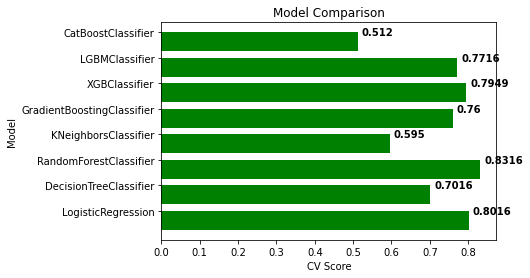

In [14]:
# plot comparison of model performance
x = names
y = scores

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
    ax.text(v + .01, i + .25, str(v)[0:6], color='black', fontweight='bold')
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)

plt.title('Model Comparison')
plt.xlabel('CV Score')
plt.ylabel('Model')      
plt.show()
    

### d. Hyper-parameter Optimisation

In [ ]:
## WARNING ##: no need to rerun as this takes time
# fine tune best model (Random Forest) using GridSearchCV
params = {
            'n_estimators':[80, 90, 100, 110, 120],
            'max_features':['auto', 'sqrt', 'log2'],
            'class_weight':['balanced', 'balanced_subsample'],
            'min_samples_split':range(2,8),
            'min_samples_leaf':range(1,3),
        }
gcv = GridSearchCV(ran, params, cv=10).fit(X_train, y_train)

In [ ]:
print(f'Best params:{gcv.best_params_}')
print(f'Best score:{gcv.best_score_}')

### e. Tuned Model Performance on Test Set

In [15]:
# performance of the tuned model (random forest) on the test set and display classification report
ran_best = RandomForestClassifier(random_state=50, class_weight='balanced_subsample', max_features='auto', min_samples_leaf=1, min_samples_split=4, n_estimators=90).fit(X_train, y_train)
predictions = ran_best.predict(X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        29
           1       0.69      0.86      0.77        21

    accuracy                           0.78        50
   macro avg       0.78      0.79      0.78        50
weighted avg       0.80      0.78      0.78        50



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

## B. Analyses

### a. ROC Curve

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


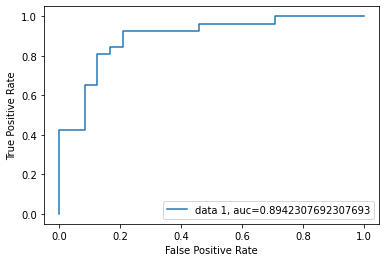

In [16]:
# ROC curve of the test set performance
def roc(model, dev_x, dev_y):
    y_pred_proba = model.predict_proba(dev_x)[::,1]
    fpr, tpr, _ = roc_curve(dev_y,  y_pred_proba)
    auc = roc_auc_score(dev_y, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
roc(ran_best, X_test, y_test)

### b. Top Feature Predictors

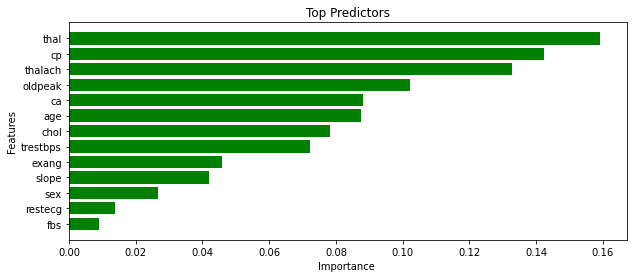

In [17]:
# top feature predictors 
imp_feature = pd.DataFrame({'Feature': cols[0:-1], 'Importance': ran_best.feature_importances_}).sort_values(by='Importance',ascending=True)
plt.figure(figsize=(10,4))
plt.title("Top Predictors")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'green')
plt.show()

In [18]:
# save notebook session
dill.dump_session('notebook_env.db')